In [1]:
using LinearAlgebra
using JuMP
using Ipopt
using Plots
using GLPKMathProgInterface
using Juniper
using GLPK
using StatsBase

include("market_pab_ver.3.jl")

market (generic function with 1 method)

#### 1. Initial data

In [2]:
#BEGIN: DSO:Flexibility requirements
T = 85;#days
Δt = 2;#hours
Eexp = 1;#MWh
D = 2.0;
w1 = 1; #?
w2 = Eexp/(D*T*Δt); #?
#END: DSO:Flexibility requirements

In [3]:
#BEGIN: Agents: true offers
#CAPtr = [247	306	385	438	495	544	603	658	710	745	790	820	860	886	910	946	968	989	1009	1042	1061	1080	1098	1120	1121	1123	1124	1127	1127	1141	1141	1142	1142	1143	1143	1143	1144	1144	1144	1145	1145	1145	1145	1145	1146	1146	1146	1146	1146	1146	1147	1147	1147	1147	1147	1147	1147	1147	1147	1148	1148	1148	1148	1148	1148	1148	1148	1148	1148	1148	1148	1148	1148	1149	1149]/1000;#Scenario: System transformation
CAPtr = [647	865	1010	1117	1248	1372	1505	1627	1737	1819	1908	1972	2046	2098	2128	2163	2178	2191	2202	2229	2237	2245	2252	2275	2281	2286	2290	2298	2300	2319	2320	2322	2323	2325	2326	2327	2328	2329	2330	2331	2332	2333	2333	2334	2335	2335	2336	2336	2337	2337	2338	2338	2339	2339	2339	2340	2340	2340	2341	2341	2341	2342	2342	2342	2342	2343	2343	2343	2343	2343	2344	2344	2344	2344	2344]/1000;#Scenario: Consumer transformation
#CAPtr = [701	993	1166	1293	1448	1597	1788	1966	2129	2225	2364	2438	2558	2619	2654	2729	2747	2763	2776	2842	2852	2861	2870	2931	2937	2943	2949	2959	2960	3016	3018	3020	3022	3023	3025	3026	3028	3029	3030	3031	3032	3033	3034	3035	3036	3036	3037	3038	3038	3039	3039	3040	3040	3041	3041	3042	3042	3043	3043	3043	3044	3044	3044	3045	3045	3045	3046	3046	3046	3046	3047	3047	3047	3047	3047]/1000;#Scenario: Leading the way
#CAPtr = [758	970	1087	1177	1278	1375	1521	1660	1791	1862	1981	2041	2151	2203	2228	2293	2301	2309	2315	2375	2380	2385	2388	2446	2449	2452	2455	2459	2460	2515	2516	2517	2518	2519	2520	2520	2521	2522	2522	2523	2523	2524	2524	2524	2525	2525	2525	2526	2526	2526	2527	2527	2527	2527	2528	2528	2528	2528	2528	2528	2529	2529	2529	2529	2529	2529	2530	2530	2530	2530	2530	2530	2530	2530	2530]/1000;#Scenario: Net zero early
PRItr = [1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75];

In [4]:
# distribution of the demand between the agents
A = 2; #?
max_price = maximum(PRItr)
σ = zeros(A); #?

for a=1:A
    σ[a] = A/a;
end
σ = σ/sum(σ)
print(σ);

[0.6666666666666666, 0.3333333333333333]

In [5]:
# BEGIN: Agents: true offers
N = size(CAPtr,2); #points num
o = zeros(A,N); #дейст. знач. мощности
cav = zeros(A,N); #действ. стоимость ставок

for a=1:A
    o[a,1] = CAPtr[1]*σ[a];
    cav[a,1] = PRItr[1];
    for n=2:N
        o[a,n] = (CAPtr[n] - CAPtr[n-1])*σ[a];
        cav[a,n] = PRItr[n];
    end
end

#Δcav =  ones(A)' - 0.2*rand(1,A);
Δcav =  ones(A) - 0.2*σ; #разные шаги. Шаг изменения стоимости
ϵ = 0.0001;
#END: Agents: true offers

> логика задания начальных предложений

In [6]:
M = 200; #огр. по шагам
O = zeros(M,A,N); #офферы объема по времени
Cav = zeros(M,A,N); #ставки по времени (aval. fee)
Cut = zeros(M,A,N); #(util. fee)
g = ones(1,A); #номер марж. ставки

for m=1:M
    Cav[m,:,:] = cav;
end

#BEGIN: Offering true costs
Cav[1,:,:] = cav;
O[1,:,:] = market(w1,w2,D,o,Cav[1,:,:],Cut[1,:,:]);
#END: Offering true costs


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [7]:
#определение марж. - чувств.
for a=1:A
    g[a] = 1;
    while o[a,Int(g[a])] - O[1,a,Int(g[a])] <= ϵ #Check if infra-marginal
        g[a] = g[a] + 1;
    end
    Cav[2,a,1:Int(g[a])] = ones(Int(g[a]),1)*PRItr[Int(g[a])]; #при. стоим. марж
end

m = 1;

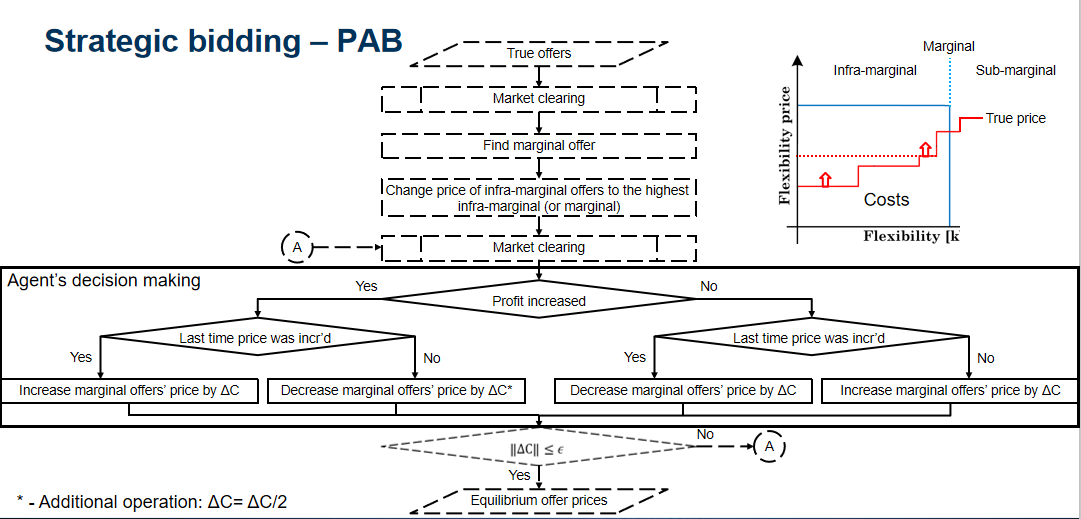

In [8]:
stop_e = 1e-6

while (sum(norm(Cav[m+1,a,:]-Cav[m,a,:] for a=1:A) for a=1:A) >= stop_e) && (m < M-2)
        
    global m = m + 1;
    O[m,:,:] = market(w1,w2,D,o,Cav[m,:,:],Cut[m,:,:]);
    for a=1:A
        if O[m,a,:]'*(Cav[m,a,:] - cav[a,:]) >= O[m-1,a,:]'*(Cav[m-1,a,:] - cav[a,:])
            if Δcav[a] >= 0
                if g[a] < N
                    Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])] + ones(Int(g[a]))*Δcav[a];
                else
                    Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])];
                end
                if Int(g[a]) < N
                    if Cav[m+1,a,Int(g[a])] > Cav[m+1,a,Int(g[a])+1]
                        Cav[m+1,a,Int(g[a])+1] = Cav[m+1,a,Int(g[a])];
                        g[a] = g[a] + 1;
                    end
                end
            else
                Δcav[a] = -Δcav[a]/2;
                if Cav[m,a,Int(g[a])] + Δcav[a] < cav[a,Int(g[a])]
                    Cav[m+1,a,Int(g[a])] = cav[a,Int(g[a])];
                    g[a] = g[a] - 1;
                end
                Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])] + ones(Int(g[a]))*Δcav[a];
            end
        else
            if Δcav[a] >= 0
                Δcav[a] = -Δcav[a];
                if Cav[m,a,Int(g[a])] + Δcav[a] < cav[a,Int(g[a])]
                    Cav[m+1,a,Int(g[a])] = cav[a,Int(g[a])];
                    g[a] = g[a] - 1;
                end
                Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])] + ones(Int(g[a]))*Δcav[a];
            else
                Δcav[a] = -Δcav[a];
                if g[a] < N
                    Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])] + ones(Int(g[a]))*Δcav[a];
                else
                    Cav[m+1,a,1:Int(g[a])] = Cav[m,a,1:Int(g[a])];
                end
                if Int(g[a]) < N
                    if Cav[m+1,a,Int(g[a])] > Cav[m+1,a,Int(g[a])+1]
                        Cav[m+1,a,Int(g[a])+1] = Cav[m+1,a,Int(g[a])];
                        g[a] = g[a] + 1;
                    end
                end
            end
        end
    end
end


#### 2. Simulation based on the original algorithm

- 2 agents

In [70]:
#y - дейст. ставка
#x - шаг
plot(xlim=(0, m+40))
plot!(Cav[:, 1, :]);

Минимальная конечная ставка: 74.64843755165728
Общая полезность: 149.99999859132257
Выгода DSO: 0.6979951306318273
Выгода агентов: 149.30200346069105


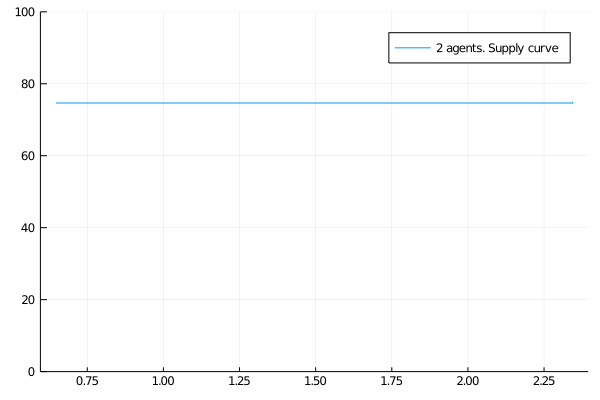

In [232]:
print("Минимальная конечная ставка: ", minimum(Cav[m, 1, :]), '\n')
print("Общая полезность: ", sum(O[m,a,n] for a=1:A,n=1:N) * max_price, '\n')
print("Выгода DSO: ", sum(O[m,a,n]*(max_price - Cav[m,a,n]) for a=1:A,n=1:N), '\n')
print("Выгода агентов: ", sum(O[m,a,n]*(Cav[m,a,n]) for a=1:A,n=1:N), '\n')

plot(ylim=(0, 100))
plot!(CAPtr', Cav[m, 1, :], label=string(A, " agents. Supply curve") )

- 3 agents

In [397]:
#y - дейст. ставка
#x - шаг
plot(xlim=(0, m+40))
plot!(Cav[:, 1, :]);

Минимальная конечная ставка: 75.02948831644923
Общая полезность: 149.999998590872
Выгода DSO: -0.048464440147455976
Выгода агентов: 150.04846303101928


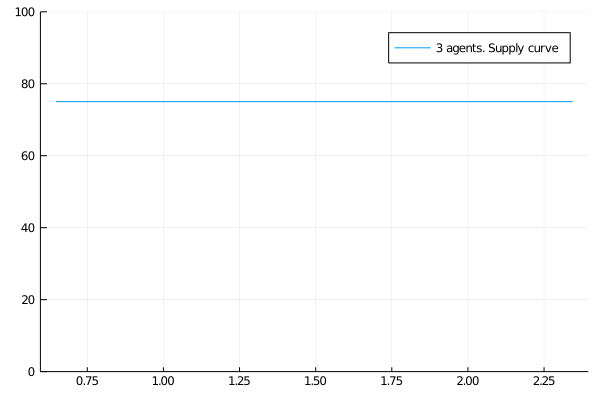

In [239]:
print("Минимальная конечная ставка: ", minimum(Cav[m, 1, :]), '\n')
print("Общая полезность: ", sum(O[m,a,n] for a=1:A,n=1:N) * max_price, '\n')
print("Выгода DSO: ", sum(O[m,a,n]*(max_price - Cav[m,a,n]) for a=1:A,n=1:N), '\n')
print("Выгода агентов: ", sum(O[m,a,n]*(Cav[m,a,n]) for a=1:A,n=1:N), '\n')

plot(ylim=(0, 100))
plot!(CAPtr', Cav[m, 1, :], label=string(A, " agents. Supply curve") )

- 10 agents

In [245]:
#y - дейст. ставка
#x - шаг
plot(xlim=(0, m+40))
plot!(Cav[:, 1, :]);

Минимальная конечная ставка: 21.82947042871933
Общая полезность: 149.99999881229235
Выгода DSO: 106.34572823850817
Выгода агентов: 43.654270573784395


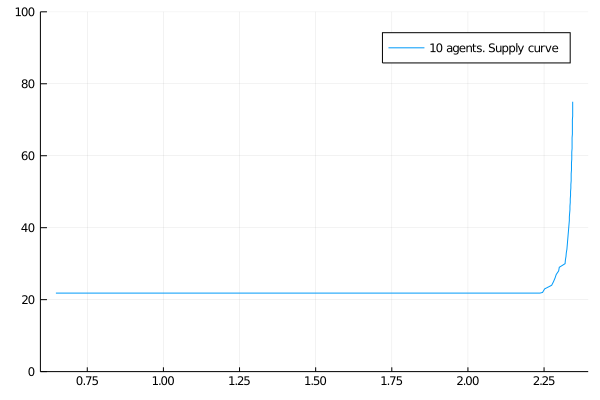

In [246]:
print("Минимальная конечная ставка: ", minimum(Cav[m, 1, :]), '\n')
print("Общая полезность: ", sum(O[m,a,n] for a=1:A,n=1:N) * max_price, '\n')
print("Выгода DSO: ", sum(O[m,a,n]*(max_price - Cav[m,a,n]) for a=1:A,n=1:N), '\n')
print("Выгода агентов: ", sum(O[m,a,n]*(Cav[m,a,n]) for a=1:A,n=1:N), '\n')

plot(ylim=(0, 100))
plot!(CAPtr', Cav[m, 1, :], label=string(A, " agents. Supply curve") )

#### 3. Implementation of RL algorithms 
(in progress)

- Roth-Erev

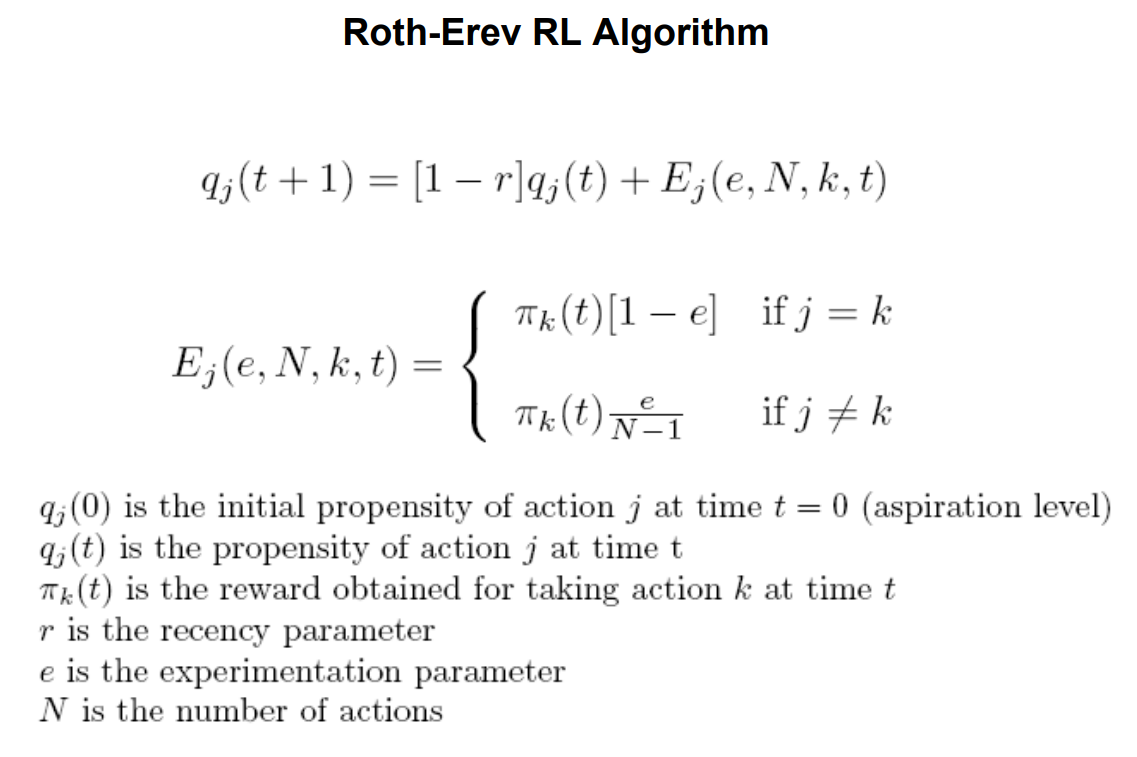

In [5]:
#used functions
function updatePriceProbabilities(m, N, agent, reward, propensity, choice, memory_param, experimental_param)
    for price=1:N
        if price == Int(choice[m, agent])
            propensity[m+1, price] = (1 - memory_param) * propensity[m, price] + reward * (1 - experimental_param)
        else
            propensity[m+1, price] = (1 - memory_param) * propensity[m, price] + reward * (experimental_param / (N -1))
        end
    end
    return propensity
end


function updatePriceProbabilities(m, N, agent, propensity, probability)
    for price=1:N
        probability[m, price]  = propensity[m, price] / sum(propensity[m, :])
    end
    return probability
end

function choosePrice(cav, probability)
    priceSet = cav[1, :]'
    weights = probability[m, :]
    choice = sample(priceSet, ProbabilityWeights(weights))
    return choice
end

choosePrice (generic function with 1 method)

In [18]:
# distribution of the demand between the agents
m = 1
M = 200 #number of iterations
A = 10  #number of agents
N = size(CAPtr,2); #points num


max_price = maximum(PRItr)
σ = zeros(A); #?

for a=1:A
    σ[a] = A/a;
end
σ = σ/sum(σ)

# BEGIN: Agents: true offers
o = zeros(A,N); #дейст. знач. мощности
cav = zeros(A,N); #действ. стоимость ставок


for a=1:A
    o[a,1] = CAPtr[1]*σ[a];
    cav[a,1] = PRItr[1];
    for n=2:N
        o[a,n] = (CAPtr[n] - CAPtr[n-1])*σ[a];
        cav[a,n] = PRItr[n];
    end
end
#END: Agents: true offers

In [19]:
#initial values
choice = zeros(M,A); 
priceStrategies = cav[1, :]'
probability = ones(M,N);
propensity = ones(M,N);
O = zeros(M,A,N);
Cav = zeros(M,A,N);
Cut = zeros(M,A,N); 

#RL params
memory_param = 0.2
experimental_param = 0.8


#set the initial offers of agents
choice[1, :] = rand(1:N,A)
priceStrategies = cav[1, :]'

for agent=1:A
    agent_choice = Int(choice[1, agent])
    Cav[1,agent,:] = cav[1, :]'
end

In [20]:
while (m < M-1)

    O[m,:,:] = market(w1,D,o,Cav[m,:,:])
    
    for agent=1:A
        #init values
        agent_choice = Int(choice[m, agent])
        #print(agent_choice, '\n')
        reward = O[m,agent,:]'*(Cav[m,agent,:]) 
        #print(agent_choice, " - ", O[m,agent,agent_choice])
        
        #Roth-Erev
        propensity = updatePriceProbabilities(m, N, agent, reward, propensity, choice, memory_param, experimental_param)
        probability = updatePriceProbabilities(m, N, agent, propensity, probability)
        agent_price = choosePrice(cav, probability)
        
        #update
        choice[m+1, agent] = Int(agent_price)
        Cav[m+1,agent,:] = cav[1, :]'
        Cav[m+1,agent,1:agent_choice] = ones(agent_choice,1)' * agent_price
    end
    global m = m + 1;
end 

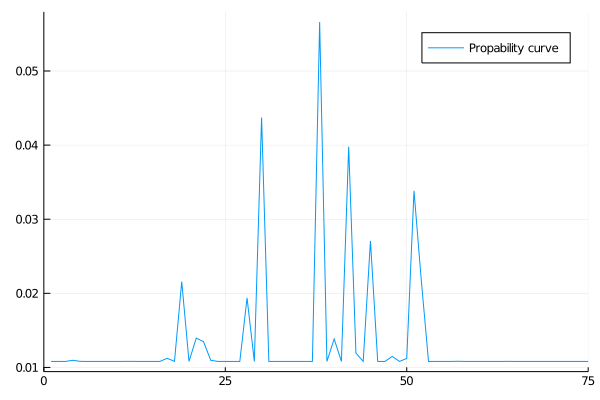

In [21]:
#probability distribution of the agent's choice of price
plot(xlim=(0, N))
plot!(cav[1, :, :], probability[M-2, :], label=string("Propability curve") )